In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from math import gamma

In [2]:
# === Parameters ===
alpha = 2.0       # Weibull shape
beta = 10.0       # Weibull scale (months)
HORIZON = 120.0   # months (10 years)
TRIALS = 5000
np.random.seed(42)

In [4]:
# Theoretical mean and renewal rate
E_X = beta * gamma(1 + 1/alpha)
theoretical_rate = 1.0 / E_X

print(f"Theoretical E[X] = {E_X:.4f} months")
print(f"Theoretical renewal rate = {theoretical_rate:.6f} renewals/month")

Theoretical E[X] = 8.8623 months
Theoretical renewal rate = 0.112838 renewals/month


In [5]:
# --- Function: simulate one renewal path without preventive replacement ---
def simulate_renewals_simple(horizon, alpha, beta):
    times = []           # renewal (replacement) event times
    t=0.0
    cnt=0
    while t< horizon:
        lifetime=np.random.weibull(alpha)*beta
        t+=lifetime

        if t <=horizon:
            times.append(t)
            cnt+=1

    return  np.array(times) , cnt


In [6]:
def simulate_renewals_preventive(horizon, alpha, beta, T_p):
    times = []
    t = 0.0
    count = 0
    failures = 0
    preventives = 0
    while t < horizon:
        lifetime = np.random.weibull(alpha) * beta
        used = min(lifetime, T_p)
        t += used
        if t <= horizon:
            times.append(t)
            count += 1
            if lifetime <= T_p:
                failures += 1
            else:
                preventives += 1
    return np.array(times), count, failures, preventives

In [7]:
# --- Monte Carlo: estimate N(HORIZON)/HORIZON ---
counts = []
for _ in range(TRIALS):
    _, c = simulate_renewals_simple(HORIZON, alpha, beta)
    counts.append(c)
counts = np.array(counts)
empirical_rate = counts.mean() / HORIZON
print(f"Simulated average renewals (per trial) = {counts.mean():.3f}")
print(f"Empirical renewal rate = {empirical_rate:.6f} renewals/month")

Simulated average renewals (per trial) = 13.188
Empirical renewal rate = 0.109897 renewals/month


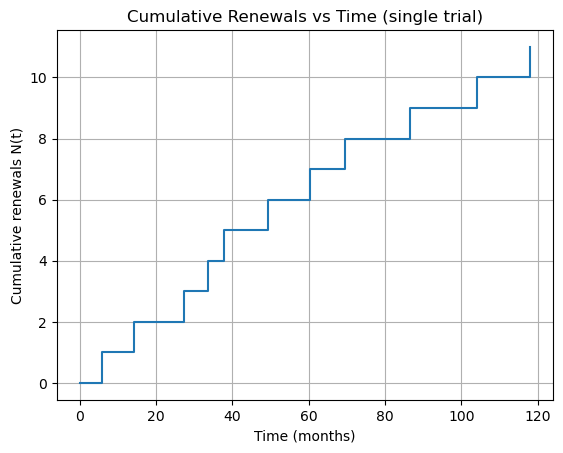

In [8]:
# --- Plot example cumulative renewals vs time (single trial) ---
times_example, _ = simulate_renewals_simple(HORIZON, alpha, beta)
plt.step(np.concatenate([[0], times_example]), np.arange(len(times_example)+1), where='post')
plt.xlabel("Time (months)")
plt.ylabel("Cumulative renewals N(t)")
plt.title("Cumulative Renewals vs Time (single trial)")
plt.grid(True)
plt.show()

In [9]:
# --- Preventive policy: compute expected cost per month for T_p = 8 months ---
C_fail = 5000.0
C_prev = 3000.0
T_p = 8.0

# Run trials
total_costs = []
for _ in range(TRIALS):
    _, count, failures, preventives = simulate_renewals_preventive(HORIZON, alpha, beta, T_p)
    cost = failures * C_fail + preventives * C_prev
    cost_per_month = cost / HORIZON
    total_costs.append(cost_per_month)
avg_cost_per_month = np.mean(total_costs)
print(f"Avg cost per month with T_p={T_p} months: ₹{avg_cost_per_month:.2f}")


Avg cost per month with T_p=8.0 months: ₹586.20


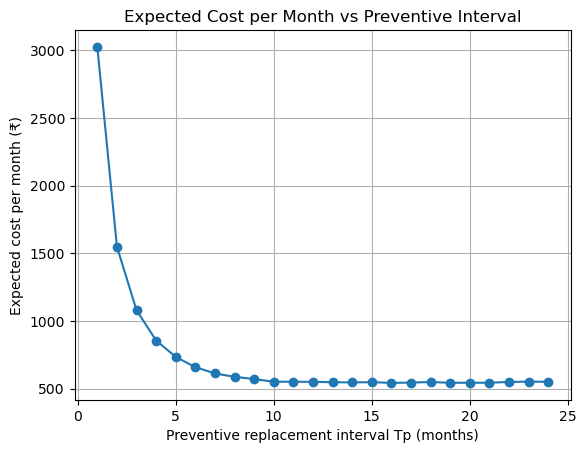

In [10]:
# --- Optional: sweep T_p values to find roughly optimal policy ---
Tp_candidates = np.arange(1, 25)  # months
avg_costs = []
for Tp in Tp_candidates:
    costs = []
    for _ in range(1000):   # fewer trials per candidate for speed
        _, _, failures, preventives = simulate_renewals_preventive(HORIZON, alpha, beta, Tp)
        cost = failures * C_fail + preventives * C_prev
        costs.append(cost / HORIZON)
    avg_costs.append(np.mean(costs))

plt.plot(Tp_candidates, avg_costs, marker='o')
plt.xlabel("Preventive replacement interval Tp (months)")
plt.ylabel("Expected cost per month (₹)")
plt.title("Expected Cost per Month vs Preventive Interval")
plt.grid(True)
plt.show()


In [11]:
# Print best candidate
best_idx = np.argmin(avg_costs)
print(f"Rough optimal Tp ≈ {Tp_candidates[best_idx]} months with cost ₹{avg_costs[best_idx]:.2f}/month")

Rough optimal Tp ≈ 16 months with cost ₹542.45/month
